# 0. Settings and Utils

In [1]:
# Required Imports
from pymongo import MongoClient
import os
import pandas as pd
from IPython.display import display
from aco.aco_final.MuseumGraphManager import MuseumGraphManager
from aco.aco_final.AlgorithmController import AlgorithmController
import json
from collections import defaultdict
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle

In [2]:
# Dataframe display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option('all')

In [3]:
# DB Connection
CONNECTION_URI = os.getenv("MONGO_CONNECT")
client = MongoClient(CONNECTION_URI, connect=False)
db = client.virtualmuseum
Users = db['users']

# [OPTIONAL] CAUTION!! 
# DELETE VISITS
# Users.update_one({}, {"$set": {"visits": []}})

In [4]:
# Helper Utility Functions
PHEROMONE_CATEGORIES = ["C1", "C2", "C3", "C4"]

def _classify_pheromone(pheromone, rho_min, rho_max):
    l1 = _calculate_limit_for_interval(rho_min, rho_max, 1)
    l2 = _calculate_limit_for_interval(rho_min, rho_max, 2)
    l3 = _calculate_limit_for_interval(rho_min, rho_max, 3)
    l4 = _calculate_limit_for_interval(rho_min, rho_max, 4)

    if pheromone <= l1:
        return PHEROMONE_CATEGORIES[0]
    elif l1 < pheromone <= l2:
        return PHEROMONE_CATEGORIES[1]
    elif l2 < pheromone <= l3:
        return PHEROMONE_CATEGORIES[2]
    elif l3 < pheromone <= l4:
        return PHEROMONE_CATEGORIES[3]
    else:
        if pheromone > rho_max:
            print(f"Warning: Pheromone value is more than max. Value: {pheromone}. Max: {rho_max}")
            return PHEROMONE_CATEGORIES[0]
        elif pheromone < rho_min:
            print(f"Warning: Pheromone value is more than min. Value: {pheromone}. Mix: {rho_min}")
            return PHEROMONE_CATEGORIES[3]
            

def _calculate_limit_for_interval(rho_min, rho_max, interval: int):
    """ Interval [1,2,3,4] """
    return rho_min + (interval / 4) * (rho_max - rho_min)

def _get_last_iteration_of_state(current_state, current_state_index, state_list):
    previous_states = state_list[:current_state_index+1]
    iterations_elapsed = 0
    for st in previous_states:
        iterations_elapsed+= st.limit
    return iterations_elapsed

def _get_colors_for_pheromone_categories(available_pheromone_categories, pastel_colors):
    """ Returns list of colors for each pheromone category. The first color corresponds
    to the first category in the provided list, the second color to the second category..."""
    pheromone_category_color_map = dict(zip(PHEROMONE_CATEGORIES, pastel_colors))
    filtered_pastel_colors = []
    for available_ph_cat in available_pheromone_categories:
        required_color = pheromone_category_color_map[available_ph_cat]
        filtered_pastel_colors.append(required_color)
    
    return filtered_pastel_colors

def _get_route_edges(node_list):
    list_size = len(node_list)
    edge_list = []
    for i in range(list_size - 1):
        u = node_list[i]
        v = node_list[i+1]
        edge_list.append((u,v))
    return edge_list   

import random

def _generate_random_float(lower_bound, upper_bound):
    if lower_bound > upper_bound:
        raise ValueError("Lower bound must be less than or equal to upper bound")
    
    random_float = random.uniform(lower_bound, upper_bound)
    return random_float

In [5]:
# Pickling Functions

# Load intermediate states if needed
def load_saved_state_pickles(state_pickles_dir):
    
    def custom_sort(element):
        no_extension = element.split('.')[0]
        return int(no_extension.split('_')[-1])
    
    def sort_list(input_list):
        return sorted(input_list, key=custom_sort)
        
    state_pickles = [f for f in listdir(state_pickles_dir) if isfile(join(state_pickles_dir, f)) and 'pickle' in str(f)]
    if len(state_pickles) == 0:
        print("ERROR: no saved state pickles found")
    
    sorted_state_pickles = sort_list(state_pickles)
    algorithm_states = []
    for sp in sorted_state_pickles:
        full_sp_path = f"{state_pickles_dir}/{sp}"
        state_instance = pickle.load(open(full_sp_path, 'rb'))
        algorithm_states.append(state_instance)
        print(f"Loaded state: {sp}")   
    
    return algorithm_states

def save_algorithm_states_to_pickles(controller, workdir):
    for n, algo_state in enumerate(controller.algorithm_states):
        intermediate_state_name = f"intermediate_state_{limit}iters_{n+1}"
        path_to_pkl = f"{workdir}/{intermediate_state_name}.pickle"
        pickle.dump(algo_state, open(path_to_pkl, 'wb'))
        print(f"Saved state: {intermediate_state_name}")


def save_algorithm_controller_to_pickle(controller, workdir, pickle_name):
    os.makedirs(workdir, exist_ok = True) 
    path_to_pkl = f"{workdir}/{pickle_name}.pickle"
    pickle.dump(controller, open(path_to_pkl, 'wb'))
    print(f"Saved controller: {pickle_name}")

def load_saved_algorithm_controller(workdir, saved_controller_pickle_name):
    full_path_pickle_controller = f"{workdir}/{saved_controller_pickle_name}.pickle"
    algorithm_controller = pickle.load(open(full_path_pickle_controller, 'rb'))
    return algorithm_controller

In [6]:
# Main Utility Functions

def get_dataframe_pheromone_categorisations_of_state(state):
    """ Categorises Pheromones into their corresponding Interval (I1, I2, I3, I4)
    for each saved state.
    The returned dataframe represents the pheromone distribution by each interval; 
    """
    # states = algorithm_controller.algorithm_states  # algorithm_controller.graph
    # for idx, state in enumerate(states):
    graph = state.graph
    rho_max = state.current_upper_bound
    rho_min = state.current_lower_bound
    data1 = {'Pheromone': [], 'Category': []}
    # data2 = {ph_cat: [0] for ph_cat in PHEROMONE_CATEGORIES}
    for edge in graph.edges():
        u, v = edge
        ph = graph[u][v]["pheromone"]
        if ph > state.current_upper_bound:
            ph = state.current_upper_bound*_generate_random_float(0.9801, 1.0)
        ph_interval = _classify_pheromone(ph, rho_min, rho_max)
        data1['Pheromone'].append(ph)
        data1['Category'].append(ph_interval)

        # current_sum_in_interval = data2[ph_interval][0]
        # data2[ph_interval] = [current_sum_in_interval + 1]
    df1 = pd.DataFrame(data1)
    # df2 = pd.DataFrame.from_dict(data2)
    return df1

def get_dataframe_pheromone_distribution_across_states(states):
    df = pd.DataFrame()
    for idx, st in enumerate(states):
        graph = st.graph
        total_iterations = _get_last_iteration_of_state(st, idx, states)
        for edge in graph.edges():
            d = {"Pheromone": [], "Iteration": []}
            u, v = edge
            ph = graph[u][v]["pheromone"]
            if ph > st.current_upper_bound:
                ph = st.current_upper_bound*_generate_random_float(0.9801, 1.0)
            d['Pheromone'].append(ph)
            d['Iteration'].append(total_iterations)
            df = pd.concat([df, pd.DataFrame(d)], ignore_index=True)
    return df

def train_traditional_mmas_model(algorithm_controller, total_iterations=50, save_state_every_x_iterations=10):
    if total_iterations % save_state_every_x_iterations:
        print("ERROR. Specify a checkpoint value that is multiple of the total number of iterations to compute")

    total_states_to_save = int(total_iterations/save_state_every_x_iterations)
    for i in range(total_states_to_save):
        if i == 0:
            algorithm_controller.compute_initial_iterations(limit=save_state_every_x_iterations)
        else:
            algorithm_controller.compute_next_iterations(limit=save_state_every_x_iterations)
    return algorithm_controller

def train_iml_mmas_model(algorithm_controller, routes_list, starting_iterations=15, 
                         iterations_after_every_feedback=5, manual_pheromone_multiplier=100000000):
    
    algorithm_controller.compute_initial_iterations(limit=starting_iterations)
    
    for route_idx, route in enumerate(routes_list):
        nodes_in_route = route["route"]
        route_repetitions = route["repetitions"]
        route_name = route["name"]
        current_repetitions = 0
        total_cnt = 0
        route_edges = _get_route_edges(nodes_in_route)
        
        print("\n")
        print(f"Doing Route: {route_name}")
        print("\n")
        print("\n")
        
        while current_repetitions < route_repetitions:
            
            print("\n")
            print(f"Repeating Route {current_repetitions +1}")
            print("\n")
            
            for idx, edge in enumerate(route_edges):
                total_cnt+=1
                if idx == 0 and route_idx != 0:
                    print("Next  iters with starting itertions limit")
                    algorithm_controller.compute_next_iterations(limit=starting_iterations)
                algorithm_controller.manual_pheromone_update(edge, multiplier=manual_pheromone_multiplier)
                algorithm_controller.compute_next_iterations(limit=iterations_after_every_feedback)
                print(algorithm_controller.algorithm_states[-1].limit)
            current_repetitions +=1

        # Save controller as pickle
        save_algorithm_controller_to_pickle(algorithm_controller, "mmas_iml_pickles", f'{route_name}_{route_idx}_accumulated_{total_cnt}')
            
    return algorithm_controller

In [58]:
# Main Graph Plotting Functions

def plot_pie_chart_of_pheromone_distribution_of_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml", states_of_interest=None):
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)
    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states)
    if states_of_interest is not None:
        if total_iterations not in states_of_interest:
            return
        else:
            print(f"State of interest: {idx} - iters: {state_to_analyse.current_iteration}")
        
    # plotting data on chart 
    result_df = df.groupby('Category')['Pheromone'].count().reset_index(name='Count')

    # define Seaborn color palette to use (specific to each category)
    pastels = sns.color_palette('pastel')[0:3] + [sns.color_palette('pastel')[7]]
    ordered_pastels= _get_colors_for_pheromone_categories(result_df['Category'], pastels)
    
    plt.pie(result_df['Count'], labels=result_df['Category'],
            wedgeprops={'linewidth': 1, 'linestyle': 'solid', "edgecolor":"k"},
            autopct='%.0f%%', colors=ordered_pastels)
    
    plt.title(f'Pheromone Distribution After {total_iterations} Iterations')
    
    # Save plot if specified
    if save_plot:
        name = f"pheromone_dist_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_ecdf_per_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml"):
    
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)
    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states) 
    ecdf = sns.ecdfplot(data=df,x='Pheromone')
    ecdf.set(xscale="log")

    # Show Rho_min and Rho_max
    rho_max = state_to_analyse.current_upper_bound
    rho_min = state_to_analyse.current_lower_bound
    lineprops = { "ymin": 0, "ymax" : 1, "color": "black",
                 "linewidth": 0.5, "linestyle" : "dashed"}
    textprops = {"fontsize": 11, "fontstyle": "oblique", 
                 "color" : "green", "va" : "center"}
    ecdf.axvline(x = rho_min, **lineprops)
    ecdf.axvline(x = rho_max, **lineprops)
    ecdf.text(rho_min, 0.5, r'$\tau_{min}$', **textprops)
    ecdf.text(0.92*rho_max, 0.5, r'$\tau_{max}$', **textprops)

    ecdf.set(title=f"Pheromone ECDF After {total_iterations} Iterations")
    

    # Save plot if specified
    if save_plot:
        name = f"pheromone_ecdf_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_histplot_of_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml", states_of_interest=None):

    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states) 
    
    if states_of_interest is not None:
        if total_iterations not in states_of_interest:
            return
        else:
            print(f"State of interest: {idx} - iters: {state_to_analyse.current_iteration}")
            
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)       
    sns.set_palette("pastel", 2)
    hist = sns.histplot(df['Pheromone'].to_numpy(), kde=True)
    hist.set(xscale="log")
    hist.lines[0].set_color('crimson')

    # Show Rho_min and Rho_max
    rho_max = state_to_analyse.current_upper_bound
    rho_min = state_to_analyse.current_lower_bound
    tot = int(df.shape[0])
    print(f"RHO MIN : {rho_min}")
    print(f"RHO MAX : {rho_max}")
    vals_rho_min = df[df["Pheromone"] == rho_min].shape[0]
    vals_rho_max = df[df["Pheromone"] == rho_max].shape[0]
    print(f"Pct pheromones = min {round((vals_rho_min/tot)*100,2)}")
    print(f"Pct pheromones = max {round((vals_rho_max/tot)*100,2)}")
    max_y = hist.get_ylim()[1]
    lineprops = { "ymin": 0, "ymax" : max_y, "color": "black",
                 "linewidth": 0.5, "linestyle" : "dashed"}
    textprops = {"fontsize": 11, "fontstyle": "oblique", 
                 "color" : "green", "va" : "center"}
    hist.axvline(x = rho_min, **lineprops)
    hist.axvline(x = rho_max, **lineprops)
    hist.text(rho_min, max_y/2, r'$\tau_{min}$', **textprops)
    hist.text(0.92*rho_max, max_y/2, r'$\tau_{max}$', **textprops)

    hist.set(title=f"Pheromone Histogram After {total_iterations} Iterations")
    

    # Save plot if specified
    if save_plot:
        name = f"pheromone_histplot_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_histplot_comparing_states(all_states):
    df = get_dataframe_pheromone_distribution_across_states(all_states)

In [8]:
# Load rooms json
with open('resources/space.json', 'r') as f:
    rooms_json = json.load(f)

# 1. MMAS Without Human Intervention

In [9]:
# Load MMAS MODEL

params = {
    'raw_museum_floorplan': rooms_json,
    'alpha': 1, # pheromone control parameter (higher value means less importance to pheromone)
    'beta': 3, # weight control parameter (higher value means less importance to weight)
    'rho': 0.05, # 0.02
    'pts': True,
    'pts_factor': 1,
    'num_ants': 5, #len(graph.nodes()),
    'start_node': 'D1-1',
    'start_room': 1
}
controller = AlgorithmController(**params)

### Train Model

In [10]:
def train_model_from_scratch():
    total_iterations = 3000 #11500
    save_state_every_x_iterations =  750 # 1000
    controller = AlgorithmController(**params)
    trained_controller = train_traditional_mmas_model(controller, total_iterations=total_iterations, 
                                                      save_state_every_x_iterations=save_state_every_x_iterations)
    return trained_controller

trained_controller = train_model_from_scratch()
#trained_controller = load_saved_algorithm_controller("mmas_iml_pickles", "traditional_mmas_11500iters")


Starting mmas algorithm with 750 initial iterations.
Iteration:  0
New record at iteration: 0: (48276.97)
New record at iteration: 2: (41856.06000000005)
New record at iteration: 4: (33648.74)
Iteration:  20
Iteration:  40
Iteration:  60
Iteration:  80
New record at iteration: 81: (33555.460000000014)
Iteration:  100
Iteration:  120
New record at iteration: 127: (33009.030000000006)
Iteration:  140
Iteration:  160
Iteration:  180
New record at iteration: 181: (30540.960000000017)
Iteration:  200
Iteration:  220
Iteration:  240
Iteration:  260
Iteration:  280
Iteration:  300
Iteration:  320
New record at iteration: 333: (29056.30000000001)
Iteration:  340
Iteration:  360
Iteration:  380
Iteration:  400
Iteration:  420
Iteration:  440
Iteration:  460
Iteration:  480
Iteration:  500
Iteration:  520
Iteration:  540
Iteration:  560
Iteration:  580
Iteration:  600
Iteration:  620
Iteration:  640
Iteration:  660
Iteration:  680
Iteration:  700
Iteration:  720
Iteration:  740
Finished computin

In [11]:
#for idx, ts in enumerate(trained_controller.algorithm_states):
#    print(f"{idx} - limit: {ts.limit}")

### Analyse Pheromones

#### A. Pheromone Distribution Pie Chart (Progressive Analysis)

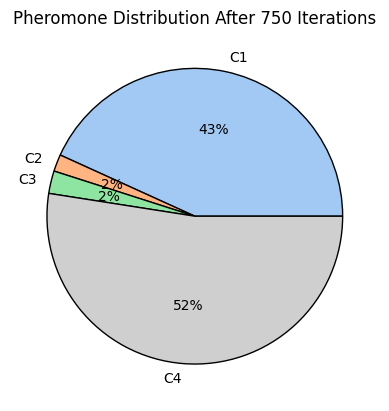

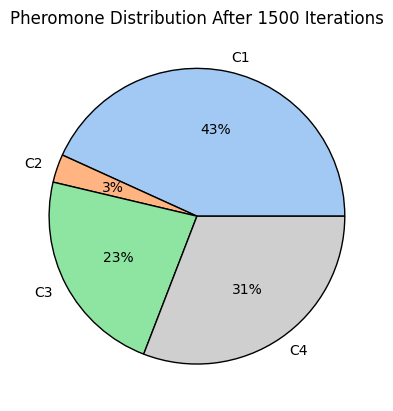

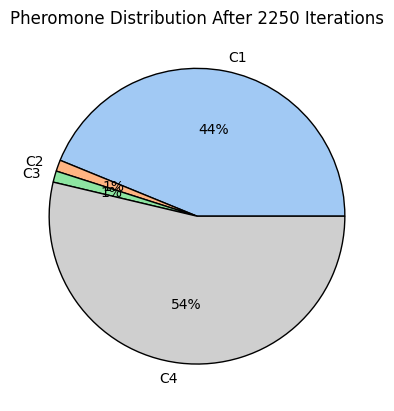

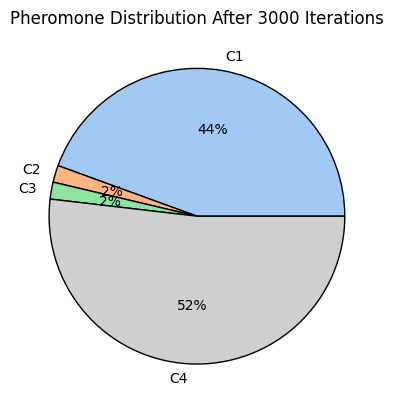

In [12]:
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pie_chart_of_pheromone_distribution_of_state(state, idx, all_states, save_plot=True, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml")

In [13]:
# controller.print_best_sol()

#### B. Pheromone CDF (Progressive Analysis)

In [88]:
save_algorithm_controller_to_pickle(trained_controller, 'mmas_iml_pickles', 'traditional_mmas_3000iters_final')

Saved controller: traditional_mmas_3000iters_final


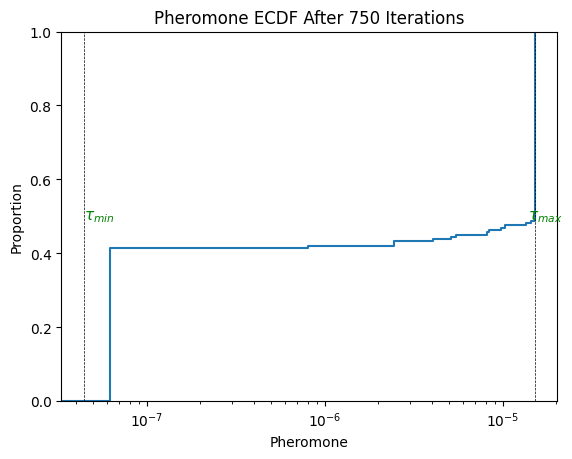

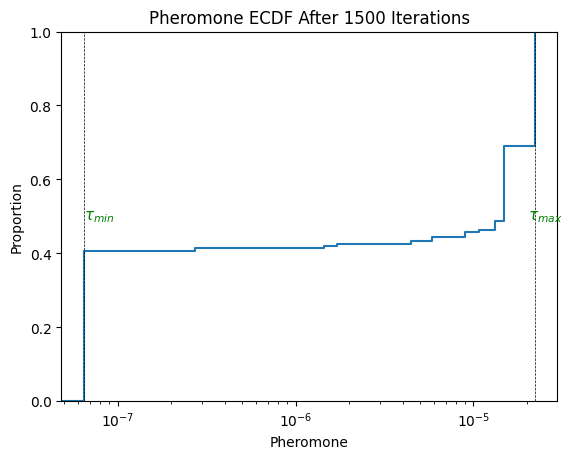

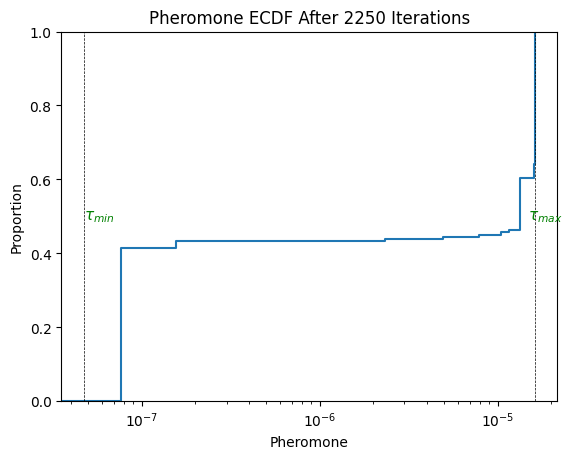

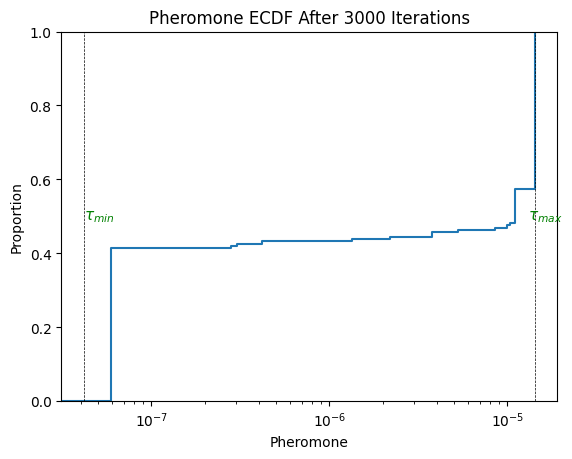

In [15]:
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pheromone_ecdf_per_state(state, idx, all_states, save_plot=False,
                                  saved_plots_dir="evaluation_figures/mmas_no_iml")

#### C. Pheromone Histogram (Progressive Analysis)

RHO MIN : 4.421955042318624e-08
RHO MAX : 1.5117411759421894e-05
Pct pheromones = min 0.0
Pct pheromones = max 51.23


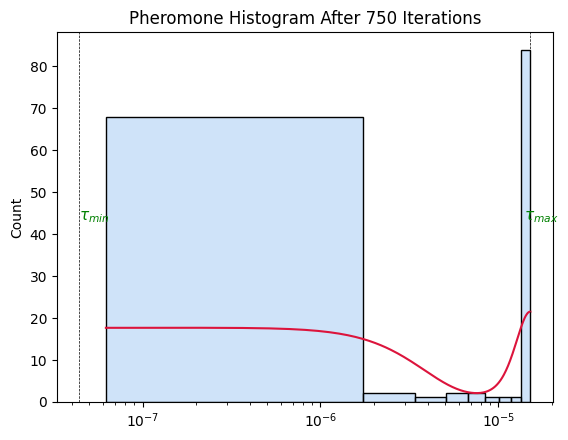

RHO MIN : 6.46372967764148e-08
RHO MAX : 2.209766089961544e-05
Pct pheromones = min 40.74
Pct pheromones = max 30.86


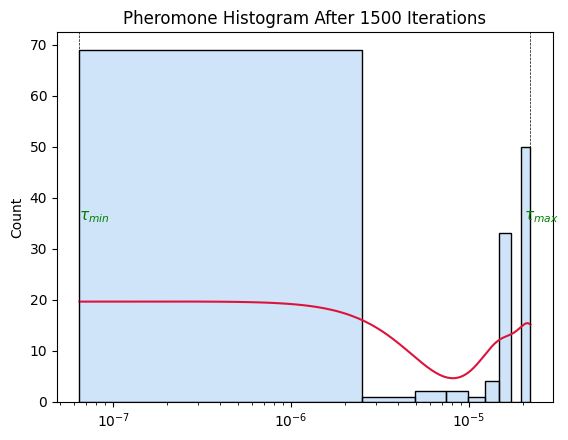

RHO MIN : 4.7343983350280034e-08
RHO MAX : 1.6185566876820064e-05
Pct pheromones = min 0.0
Pct pheromones = max 35.8


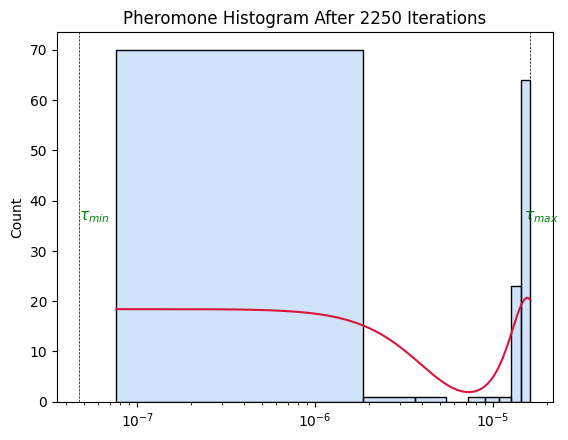

RHO MIN : 4.169196521602845e-08
RHO MAX : 1.4253301971602963e-05
Pct pheromones = min 0.0
Pct pheromones = max 42.59


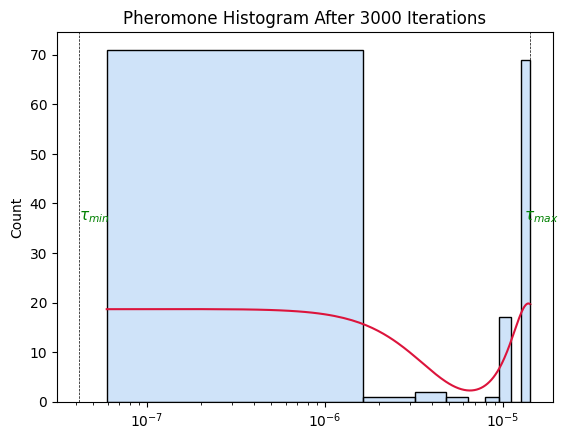

In [59]:
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pheromone_histplot_of_state(state, idx, all_states, save_plot=True,
                                  saved_plots_dir="evaluation_figures/mmas_no_iml")

#### D. Pheromone KDEPlot & ViolinPlot (Comparative Analysis)

In [17]:
mmas_states_interest = [750, 1500, 2250, 3000]
df_all_states = get_dataframe_pheromone_distribution_across_states(trained_controller.algorithm_states)
df_specific_iters = df_all_states[df_all_states["Iteration"].isin(mmas_states_interest)]

In [18]:
# DESCARTAR
#comp_ecdf = sns.ecdfplot(data=df_specific_iters,x='Pheromone', hue="Iteration", palette='icefire_r')
#comp_ecdf.set(xscale="log")
#plt.show()

In [19]:
# DESCARTAR
#comp_hst = sns.histplot(data=df_specific_iters, x='Pheromone', hue='Iteration', palette='pastel', kde=True, bins=40)
#comp_hst.set(xscale="log")
#sns.move_legend(comp_hst, "upper left", bbox_to_anchor=(1, 1))
#plt.show()

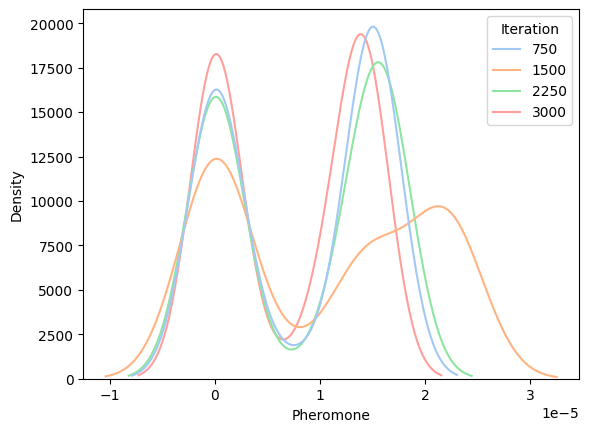

In [20]:
# INCLUDE
kdeiml = sns.kdeplot(data=df_specific_iters, hue='Iteration', x='Pheromone', palette='pastel')
plt.savefig('evaluation_figures/mmas_no_iml/kdeplot_conjunto_traditional_mmas_3000iters.png', dpi=300)
#kdeiml.set(xscale="log")

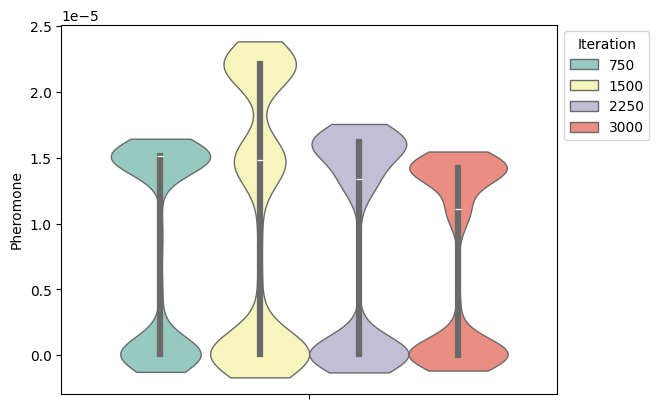

In [60]:
# INCLUDE
# https://seaborn.pydata.org/examples/wide_form_violinplot.html
comp_vp = sns.violinplot(data=df_specific_iters, hue='Iteration', y='Pheromone', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")
sns.move_legend(comp_vp, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('evaluation_figures/mmas_no_iml/violinplot_conjunto_traditional_mmas_3000iters.png', dpi=300, bbox_inches='tight')
#comp_vp.set(yscale="log")

# 2. MMAS iML

In [22]:
# Load MMAS MODEL

params = {
    'raw_museum_floorplan': rooms_json,
    'alpha': 1, # pheromone control parameter (higher value means less importance to pheromone)
    'beta': 5, # weight control parameter (higher value means less importance to weight)
    'rho': 0.02, # 0.02
    'pts': True,
    'pts_factor': 1,
    'num_ants': 5, #len(graph.nodes()),
    'start_node': 'D1-1',
    'start_room': 1
}
controller = AlgorithmController(**params)
# controller.num_ants = len(controller.graph.nodes())

In [23]:
# #### Setting different visits based on visitor profiles (based on Falk) ###
# ###########################################################################

# EXPERIENCE SEEKER
experience_seeker_route = ["D1-1", "D1-5", "The Cardinal", "D3-5","Self-portrait", "D3-4", "The Immaculate Conception", "D2-4", "Jacob's Dream",
                           "D2-11", "The Crucifixion", "D10-11", "The 3rd of May 1808 in Madrid", "D1-10", 
                           "The Garden of Earthly Delights", "D1-13", "D13-14", "Guernica", "D7-14", "D6-7", "D1-6", "The Three Graces",
                           "The Nobleman with his Hand on his Chest", "The Annunciation", "Las Meninas", "D1-1"
                          ]
experience_seeker_route_reps = 5
experience_seeker_route_name = "experience_seeker_route"

#PROFESSIONAL/HOBBYIST
professional_hobbyist_route = ["D1-1", "Las Meninas", "D1-8", "D7-8", "The Surrender of Breda", "D7-14", "Guernica",
                               "D14-15", "Gaspar de Guzmán, Count-Duke of Olivares, on Horseback", "D14-15", "D13-14",
                               "The Meadow of San Isidro", "Saturn", "D1-13", "The Garden of Earthly Delights", "D1-10", 
                               "The 3rd of May 1808 in Madrid", "D1-10", "D1-1"
                              ]
    
professional_hobbyist_route_reps = 5
professional_hobbyist_route_name = "professional_hobbyist_route"

# EXPLORER
explorer_route = ["D1-1", "Las Meninas", "The Annunciation", "D1-5", "The Cardinal", "D3-5", "Self-portrait",
                  "D3-4", "The Immaculate Conception", "D2-4", "Jacob's Dream", "D2-11", "The Crucifixion", "Christ falls on the Way to Calvary",
                  "D10-11", "Hercules fighting the Nemean Lion", "The 3rd of May 1808 in Madrid", "D10-12", "Guitar and Newspaper", "A la deriva",
                  "D10-12", "D1-10", "The Garden of Earthly Delights", "The Nobleman with his Hand on his Chest", "The Three Graces", "D1-13",
                  "Landscape with Psyche and Jupiter", "Saturn", "The Meadow of San Isidro", "D13-14", "Guernica", "D14-15", 
                  "Gaspar de Guzmán, Count-Duke of Olivares, on Horseback", "D14-15", "D7-14", "The Surrender of Breda", "D7-8",
                  "Judith at the Banquet of Holofernes", "D1-8", "D1-1"
                 ]
                  
explorer_route_reps = 5
explorer_route_name = "explorer_route"

# FACILITATOR
facilitator_route = ["D1-1", "Las Meninas", "The Annunciation", "D1-5", "The Cardinal", "D3-5", "Self-portrait",
                     "D2-3", "D2-11", "The Crucifixion", "Christ falls on the Way to Calvary", "D10-11", "Hercules fighting the Nemean Lion",
                     "The 3rd of May 1808 in Madrid", "D1-10", "The Garden of Earthly Delights", "The Three Graces", "D1-13", "Saturn",
                     "D13-14", "Guernica", "D7-14", "D6-7", "David with the Head of Goliath", "D6-7", "D7-9", "Venus and Adonis", "D7-9",
                     "D7-8", "D1-8", "D1-1"
                    ]  
                     
        
facilitator_route_reps = 5
facilitator_route_name = "facilitator_route"

routes_list = [{"route": experience_seeker_route, "repetitions": experience_seeker_route_reps, "name": experience_seeker_route_name},
               {"route": professional_hobbyist_route, "repetitions": professional_hobbyist_route_reps, "name": professional_hobbyist_route_name},
               {"route": explorer_route, "repetitions": explorer_route_reps, "name": explorer_route_name},
               {"route": facilitator_route, "repetitions": facilitator_route_reps, "name": facilitator_route_name}
              ]

In [24]:
#EDGES_LIST = list(map(lambda r: _get_route_edges(r['route']), routes_list)) # list with each element being a list of edges conforming the route
#len(EDGES_LIST[3])
#edges_count = 0
#for edge_sublist in EDGES_LIST:
#    edges_count += len(edge_sublist)
#
#(edges_count*5 + 15)*20
#print(edges_count)

In [25]:
def train_iml_from_scratch():
    controller = AlgorithmController(**params)
    trained_iml_controller = train_iml_mmas_model(controller, routes_list, starting_iterations=15, 
                                                  iterations_after_every_feedback=5, manual_pheromone_multiplier=10000000000)
    return trained_iml_controller

trained_iml_controller = train_iml_from_scratch()
# iml_states_of_interest = [750, 1500, 2250, 3000]


Starting mmas algorithm with 15 initial iterations.
Iteration:  0
New record at iteration: 0: (53192.10000000003)
New record at iteration: 1: (29765.75)
Finished computing the initial 15 iterations


Doing Route: experience_seeker_route






Repeating Route 1


Manual pheromone update of edge: ('D1-1', 'D1-5')
Continuing mmas algorithm execution with 5 more iterations.
Done 5 iterations. Waiting for more feedback
5
Manual pheromone update of edge: ('D1-5', 'The Cardinal')
Continuing mmas algorithm execution with 5 more iterations.
Iteration:  20
Done 5 iterations. Waiting for more feedback
5
Manual pheromone update of edge: ('The Cardinal', 'D3-5')
Continuing mmas algorithm execution with 5 more iterations.
Done 5 iterations. Waiting for more feedback
5
Manual pheromone update of edge: ('D3-5', 'Self-portrait')
Continuing mmas algorithm execution with 5 more iterations.
Done 5 iterations. Waiting for more feedback
5
Manual pheromone update of edge: ('Self-portrait', 'D3-4')
Continuing

In [42]:
iml_states_of_interest = [745, 1500, 2250, 3000]

In [27]:
#cdf = trained_iml_controller.pheromone_info(use_dataframe=True)
#display(cdf)

### Analyse Pheromones

#### A. Pheromone Distribution Pie Chart (Progressive Analysis)

State of interest: 144 - iters: 745


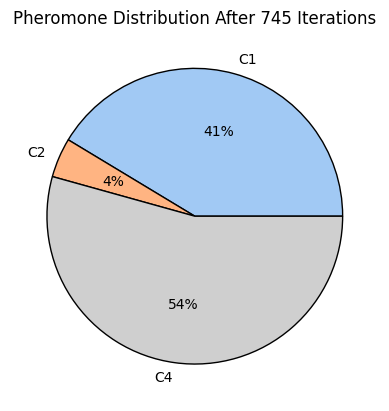

State of interest: 283 - iters: 1500


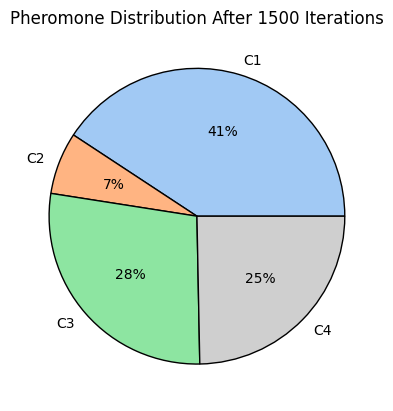

State of interest: 425 - iters: 2250


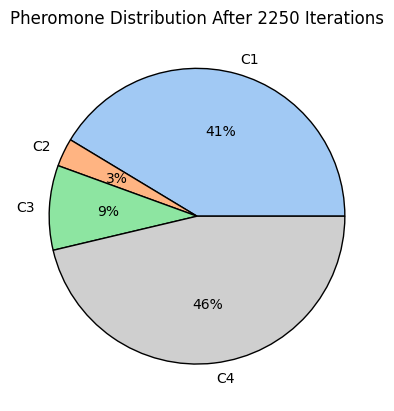

State of interest: 567 - iters: 3000


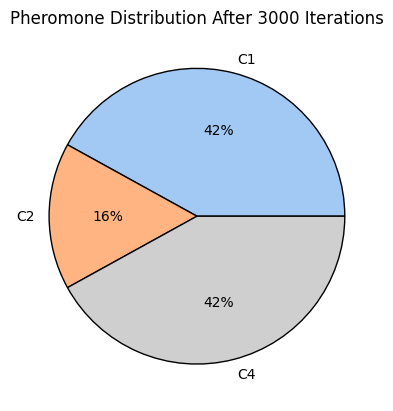

In [44]:
for idx, state in enumerate(trained_iml_controller.algorithm_states):
    plot_pie_chart_of_pheromone_distribution_of_state(state, idx, trained_iml_controller.algorithm_states, save_plot=True, 
                                                      saved_plots_dir="evaluation_figures/mmas_iml",
                                                      states_of_interest=iml_states_of_interest)

#### C. Pheromone Histogram (Progressive Analysis)

In [29]:
df = get_dataframe_pheromone_categorisations_of_state(trained_iml_controller.algorithm_states[0])
df['Pheromone'].max()

1.6894918936252922e-05

State of interest: 144 - iters: 745
RHO MIN : 5.584945241034581e-08
RHO MAX : 1.909334582883349e-05


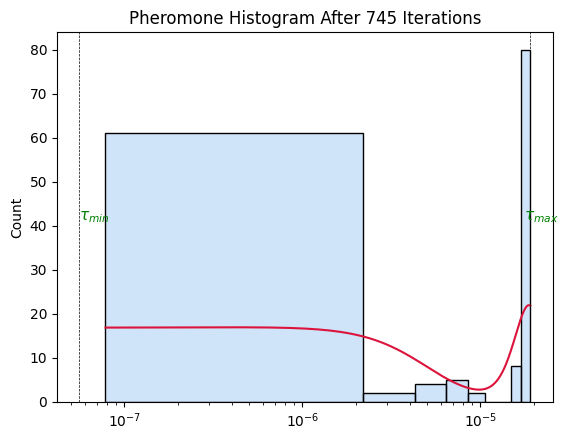

State of interest: 283 - iters: 1500
RHO MIN : 8.520281249780337e-08
RHO MAX : 2.9128428201177115e-05


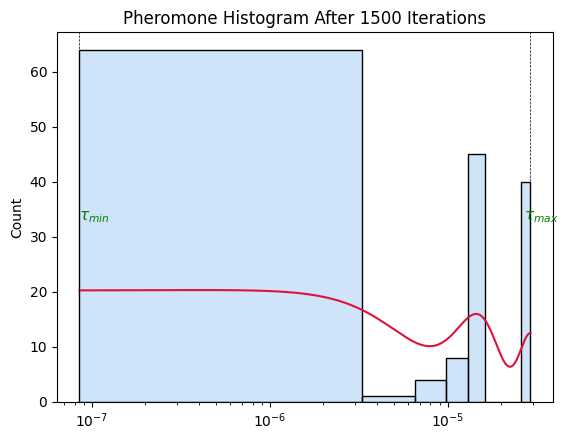

State of interest: 425 - iters: 2250
RHO MIN : 6.21149030380159e-08
RHO MAX : 2.123532592791547e-05


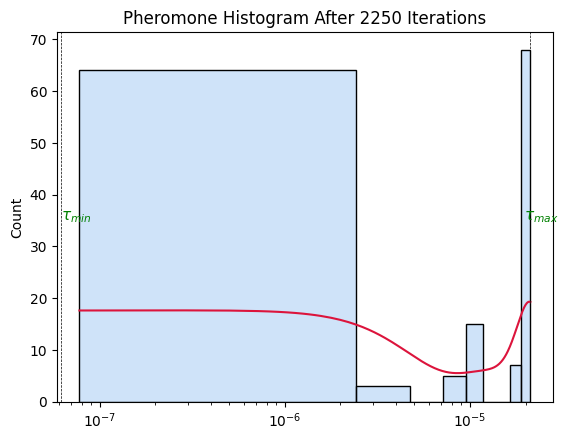

State of interest: 567 - iters: 3000
RHO MIN : 5.6661474902817147e-08
RHO MAX : 1.9370953318261167e-05


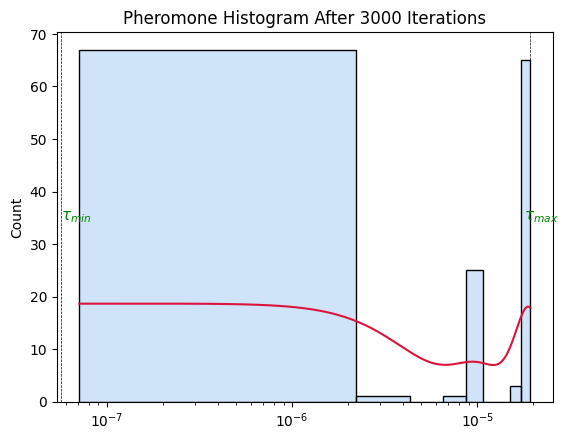

In [45]:
for idx, state in enumerate(trained_iml_controller.algorithm_states):
    plot_pheromone_histplot_of_state(state, idx, trained_iml_controller.algorithm_states, save_plot=True,
                                  saved_plots_dir="evaluation_figures/mmas_iml",
                                     states_of_interest=iml_states_of_interest)

#### D. Pheromone KDEPlot & ViolinPlot (Comparative Analysis)

In [46]:
df_all_states_iml = get_dataframe_pheromone_distribution_across_states(trained_iml_controller.algorithm_states)
df_specific_iters_iml = df_all_states_iml[df_all_states_iml["Iteration"].isin(iml_states_of_interest)]

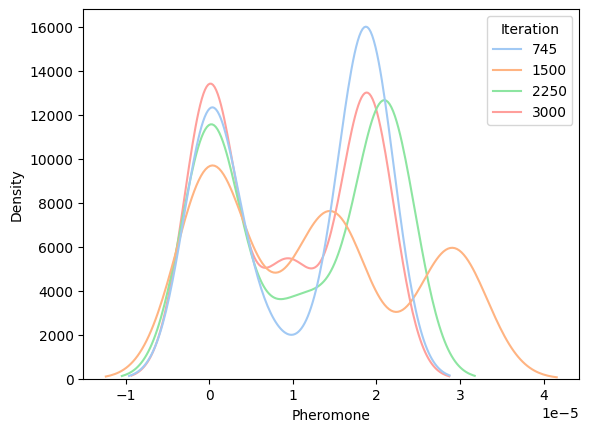

In [47]:
kdeiml = sns.kdeplot(data=df_specific_iters_iml, hue='Iteration', x='Pheromone', palette='pastel')
plt.savefig('evaluation_figures/mmas_iml/kde_conjunto_iml_mmas.png', dpi=300)

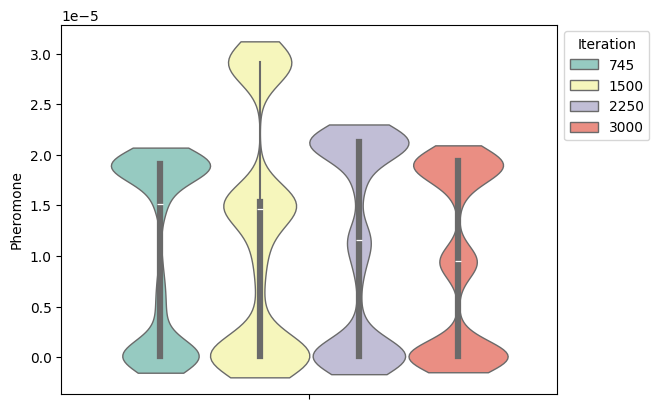

In [48]:
comp_vp = sns.violinplot(data=df_specific_iters_iml, hue='Iteration', y='Pheromone', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")
sns.move_legend(comp_vp, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('evaluation_figures/mmas_iml/violinplot_conjunto_iml_mmas.png', dpi=300, bbox_inches='tight')

## Phase 2: Evaluation

### Preparing Route Recommender

In [65]:
import networkx as nx

def get_max_pheromone_neighbor(graph, current_node):
    neighbors = list(graph.neighbors(current_node))
    
    if not neighbors:
        return None  # No neighbors

    max_pheromone_neighbor = max(neighbors, key=lambda neighbor: graph[current_node][neighbor]['pheromone'])
    
    return max_pheromone_neighbor

def explore_graph_with_max_pheromone(graph, start_node):
    current_node = start_node
    path = [current_node]
    unvisited_nodes = list(graph.nodes())
    unvisited_nodes.remove(current_node)
    
    while len(unvisited_nodes) > 0:
        max_pheromone_neighbor = get_max_pheromone_neighbor(graph, current_node)
        path.append(max_pheromone_neighbor)
        current_node = max_pheromone_neighbor

    return path

In [124]:
# Example usage:
# Assuming 'graph' is your NetworkX graph
import re
PATTERN = re.compile(r'^D\d{1,2}-\d{1,2}$')
EDGES_LIST = list(map(lambda r: _get_route_edges(r['route']), routes_list)) # list with each element being a list of edges conforming the route

def _is_door(node):
    if PATTERN.match(node):
        return True
    else:
        return False

def _get_edge_type_multiplier(u,v):

    # min_bound = 0.5
    # increment =  (1-min_bound)/3
    # increment_multiplier = 1
    
    if _is_door(u) and _is_door(v):
        increment_multiplier = 0.1
        # return 10
    elif (_is_door(u) and not _is_door(v)) or (not _is_door(u) and _is_door(v)):
        increment_multiplier = 2
        # return 1
    elif not _is_door(u) and not _is_door(v):
        increment_multiplier = 5
        #return 0.1
    else:
        raise Exception(f"Strange: {u} -> {v}")

    return increment_multiplier # min_bound + (increment*increment_multiplier)
    

def _get_user_frequency_of_edge_multiplier(u,v):
    """ Adjust pheromone value of edge taking into account
    the number of times this same edge is travelled by users
    """
    
    edge = (u,v)
    rev_edge = (v,u)
    
    multiplier = 1
    total_sublists = len(EDGES_LIST)
    for edge_sublist in EDGES_LIST:
        if edge in edge_sublist:
            multiplier *= 5 # 2 con 2 tb sale ruta interesante
        elif rev_edge in edge_sublist:
            multiplier *= 5
    
    # edge not travelled by user
    if multiplier == 1:
        multiplier = 0.1
        
    # min_bound = 0.5
    # increment_value = (1 - min_bound)/ total_sublists

    user_freq_mult = multiplier # min_bound + (increment_value*occurrences)

    # if _is_door(u) and _is_door(v):
    #     user_freq_mult = user_freq_mult * 0.8
    
    return user_freq_mult
    
def _get_ponderated_pheromones_for_edge(u,v, pheromone):
    """
    """
    user_freq_pheromone_multiplier = _get_user_frequency_of_edge_multiplier(u,v)
    edge_type_multiplier = _get_edge_type_multiplier(u,v)
    return pheromone*user_freq_pheromone_multiplier*edge_type_multiplier
    
      
    
def get_inverse_of_pheromone(graph, u,v, edge_attributes):
    "Make dijkstra algorithm get edges with greatest pheromone value"
    pheromone = graph.edges[u, v]['pheromone']
    weight = graph.edges[u, v]['weight']
    ponderated_pheromone = _get_ponderated_pheromones_for_edge(u,v,pheromone)
    # print(f"Ponderated Pheromone for ({u} , {v}) -> {ponderated_pheromone}")
    # multiplier = _get_edge_type_evaluation(u,v)
    # inv = 1/pheromone
    
    return (1/ponderated_pheromone)# (1/pheromone)*multiplier # + weight 

def get_phermone_and_weight_metric(u,v, edge_attributes):
    "Make dijkstra algorithm get edges with greatest pheromone value"
    pheromone = graph.edges[u, v]['pheromone']
    weight = graph.edges[u, v]['weight']
    ponderated_pheromone = _get_ponderated_pheromones_for_edge(u,v,pheromone)
    # print(f"Ponderated Pheromone for ({u} , {v}) -> {ponderated_pheromone}")
    # multiplier = _get_edge_type_evaluation(u,v)
    # inv = 1/pheromone
    
    return (1/ponderated_pheromone) + weight*20 #50 # (1/pheromone)*multiplier # + weight 

def get_phermone_and_weight_metric_classic_mmas(u,v, edge_attributes):
    "Make dijkstra algorithm get edges with greatest pheromone value"
    pheromone = graph.edges[u, v]['pheromone']
    return (1/pheromone)
    

In [141]:
import heapq
def clean_senseless_waypoints(graph, path):
    suggested_route_edges = _get_route_edges(path)
    nodes_to_remove = []
    for i in range(len(path) - 2):
        prev_node = path[i] 
        prev_node_attrs = graph.nodes[prev_node]
        
        current_node = path[i+1]
        current_node_attrs = graph.nodes[current_node]
        
        next_node = path[i+2]
        next_node_attrs = graph.nodes[next_node]

        # previous and next are both exhibits in the same room, if current is door means this door can be removed
        if prev_node_attrs['type'] == 'exhibit' and next_node_attrs['type'] == 'exhibit' \
            and prev_node_attrs['room'] == next_node_attrs['room'] and current_node_attrs['type'] == 'door':
            print(f"Will remove: {current_node}")
            nodes_to_remove.append(current_node)
    corrected_path = path[:]
    for n in nodes_to_remove:
        corrected_path.remove(n)

    return corrected_path
    
from copy import deepcopy

def _remove_visited_nodes(graph, path, targets):
    path_copy = path[:]
    targets_copy = targets[:]
    for target in targets:
        if target in path:
            #print(f"target {target} in path {path}")
            path_copy.remove(target)
            targets_copy.remove(target)
    #print(f"path_copy: {path_copy}")
    #print(f"targets rvn: {targets_copy}")
    graph.remove_nodes_from(path_copy[1:-1])
    return graph, targets_copy
            
    
def suggest_path_to_objectives_iml(graph, objective_nodes_list, start_node="D1-1"):
    full_route = []
    graph_track_copy = deepcopy(graph)
    updated_targets = objective_nodes_list[:]
    
    for target in objective_nodes_list:
        if target not in updated_targets:
            print(f"Target {target} no longer in targets as path already contains it")
            continue
        source = full_route[-1] if len(full_route) > 0 else start_node
        tmp_path = nx.dijkstra_path(graph_track_copy, source, target, weight=get_phermone_and_weight_metric)
        #print(f"tmp_path: {tmp_path}")
        cleaned_tmp_path = clean_senseless_waypoints(graph_track_copy, tmp_path)
        #print(f"Path from {source} to {target} is: {cleaned_tmp_path}")
        
        if source != start_node:
            cleaned_tmp_path = cleaned_tmp_path[1:]
        
        full_route = full_route + cleaned_tmp_path
            
        graph_track_copy, updated_targets = _remove_visited_nodes(graph_track_copy, 
                                                                  full_route, objective_nodes_list) # .remove_nodes_from(cleaned_tmp_path[1:-1])
        
        
    return full_route

def suggest_path_to_objectives_classic_mmas(graph, objective_nodes_list, start_node="D1-1"):
    full_route = []
    graph_track_copy = deepcopy(graph)
    print(objective_nodes_list)
    updated_targets = objective_nodes_list[:]
    for target in objective_nodes_list:
        #print(f"Target is: {target}")
        #print(f"Updated targets: {updated_targets}")
        if target not in updated_targets:
            print(f"Target {target} no longer in targets as path already contains it")
            continue
        source = full_route[-1] if len(full_route) > 0 else start_node
        tmp_path = nx.dijkstra_path(graph_track_copy, source, target, weight=get_phermone_and_weight_metric_classic_mmas)
        #print(f"tmp_path: {tmp_path}")
        cleaned_tmp_path = clean_senseless_waypoints(graph_track_copy, tmp_path)
        #print(f"Path from {source} to {target} is: {cleaned_tmp_path}")
        
        if source != start_node:
            cleaned_tmp_path = cleaned_tmp_path[1:]
            #print(f"fully cleaned path: {cleaned_tmp_path}")
        
        full_route = full_route + cleaned_tmp_path
            
        graph_track_copy, updated_targets = _remove_visited_nodes(graph_track_copy, 
                                                                       full_route, objective_nodes_list) # .remove_nodes_from(cleaned_tmp_path[1:-1])
        
    return full_route

# NEW ONE!!!!

def dijkstra_with_multiple_targets_iml(graph, source, targets, strictness_level=1):
    if source not in graph or any(target not in graph for target in targets):
        raise ValueError("Invalid source or target nodes.")

    heap = [(0, source, set(), [])]  # Priority queue (distance, current_node, visited_targets, path_so_far)
    strictness_mult_dict = {"1": 0, "2": 30, "3": 100}
    weight_multiplier = strictness_mult_dict[str(strictness_level)]
    
    while heap:
        (current_distance, current_node, visited_targets, path_so_far) = heapq.heappop(heap)
        
        if current_node in visited_targets:
            continue
        
        visited_targets.add(current_node)
        path_so_far = path_so_far + [current_node]

        if set(targets).issubset(visited_targets):
            return path_so_far

        for neighbor, edge_data in graph[current_node].items():
            distance_to_neighbor = current_distance + get_inverse_of_pheromone(graph, current_node, neighbor,edge_data) + (edge_data['weight']*weight_multiplier)
            heapq.heappush(heap, (distance_to_neighbor, neighbor, visited_targets.copy(), path_so_far))

def dijkstra_with_multiple_targets_classic_mmas(graph, source, targets, strictness_level=1):
    if source not in graph or any(target not in graph for target in targets):
        raise ValueError("Invalid source or target nodes.")

    heap = [(0, source, set(), [])]  # Priority queue (distance, current_node, visited_targets, path_so_far)
    strictness_mult_dict = {"1": 0, "2": 30, "3": 100}
    weight_multiplier = strictness_mult_dict[str(strictness_level)]
    
    while heap:
        (current_distance, current_node, visited_targets, path_so_far) = heapq.heappop(heap)
        
        if current_node in visited_targets:
            continue
        
        visited_targets.add(current_node)
        path_so_far = path_so_far + [current_node]

        if set(targets).issubset(visited_targets):
            return path_so_far

        for neighbor, edge_data in graph[current_node].items():
            distance_to_neighbor = current_distance + (1/graph.edges[current_node, neighbor]['pheromone'])
            heapq.heappush(heap, (distance_to_neighbor, neighbor, visited_targets.copy(), path_so_far))

source_node = 'D1-1'
target_nodes = ["Las Meninas", "Jacob's Dream"]

# Find the path to multiple target nodes
#try:
#    path_to_targets = dijkstra_with_multiple_targets(graph, source_node, target_nodes, strictness_level=1)
#    
#    print("Path to targets:", path_to_targets)
#except nx.NetworkXNoPath as e:
#    print(e)

### Carry out Evaluation

In [119]:
# 4 Routes based on the 4 route types, choose 3-4 objectives and evaluate. Define satisfaction metric
# TODO

#### Route 1

##### NO IML

In [131]:
final_state_no_iml = trained_controller.algorithm_states[-1]
graph = final_state_no_iml.graph

In [135]:
suggest_path_to_objectives_classic_mmas(graph, ["Las Meninas", "Guernica", "The Garden of Earthly Delights"])

['Las Meninas', 'Guernica', 'The Garden of Earthly Delights']
Target is: Las Meninas
Updated targets: ['Las Meninas', 'Guernica', 'The Garden of Earthly Delights']
tmp_path: ['D1-1', 'Las Meninas']
Path from D1-1 to Las Meninas is: ['D1-1', 'Las Meninas']
Target is: Guernica
Updated targets: ['Guernica', 'The Garden of Earthly Delights']
tmp_path: ['Las Meninas', 'D1-8', 'D1-6', 'D6-7', 'D7-14', 'Guernica']
Path from Las Meninas to Guernica is: ['Las Meninas', 'D1-8', 'D1-6', 'D6-7', 'D7-14', 'Guernica']
fully cleaned path: ['D1-8', 'D1-6', 'D6-7', 'D7-14', 'Guernica']
Target is: The Garden of Earthly Delights
Updated targets: ['The Garden of Earthly Delights']
tmp_path: ['Guernica', 'D14-15', 'D13-14', 'D1-13', 'The Three Graces', 'The Garden of Earthly Delights']
Path from Guernica to The Garden of Earthly Delights is: ['Guernica', 'D14-15', 'D13-14', 'D1-13', 'The Three Graces', 'The Garden of Earthly Delights']
fully cleaned path: ['D14-15', 'D13-14', 'D1-13', 'The Three Graces', '

['D1-1',
 'Las Meninas',
 'D1-8',
 'D1-6',
 'D6-7',
 'D7-14',
 'Guernica',
 'D14-15',
 'D13-14',
 'D1-13',
 'The Three Graces',
 'The Garden of Earthly Delights']

##### IML

In [142]:
final_state_iml = trained_iml_controller.algorithm_states[-1]
graph = final_state_iml.graph

In [144]:
suggest_path_to_objectives_iml(graph, ["Guernica", "Las Meninas", "The Garden of Earthly Delights"])

Target Las Meninas no longer in targets as path already contains it
Target The Garden of Earthly Delights no longer in targets as path already contains it


['D1-1',
 'Las Meninas',
 'The Annunciation',
 'The Nobleman with his Hand on his Chest',
 'The Garden of Earthly Delights',
 'D1-13',
 'Saturn',
 'The Meadow of San Isidro',
 'D13-14',
 'Guernica']

In [100]:
dijkstra_with_multiple_targets_iml(graph, 'D1-1', ["Guernica", "Las Meninas", "The Garden of Earthly Delights"])

['D1-1',
 'Las Meninas',
 'The Annunciation',
 'The Nobleman with his Hand on his Chest',
 'The Garden of Earthly Delights',
 'D1-13',
 'Saturn',
 'The Meadow of San Isidro',
 'D13-14',
 'Guernica']

#### MMAS IML EVALUATION

In [ ]:
final_state_iml = trained_iml_controller.algorithm_states[-1]
final_iml_graph = final_state_iml.graph

## MISC

In [ ]:
# acnew = load_saved_algorithm_controller("mmas_iml_pickles", "experience_seeker_route")

In [ ]:
# Get user with all visits
user_info = Users.find_one({}, {"visits":1, "username": 1, "_id": 0})
all_visits = user_info["visits"]
valid_visits = list(filter(lambda v: (isinstance(v,list) and len(v) > 1), all_visits))
print(f"{len(valid_visits)} visits registered.")

In [ ]:
# Make a list where each element is a dataframe representing each different visit
visits_dfs = []
for visit in valid_visits:
    df = pd.DataFrame.from_dict(visit)
    visits_dfs.append(df)

# Print Info on Visits
for idx, visit_df in enumerate(visits_dfs):
    
    print("**************")
    print(f"Visit {idx+1}")
    print("**************")
    
    display(df.head())
    print("\n")
    
print("-------------------")
print(f"TOTAL VISITS: {len(visits_dfs)}")

In [ ]:
# MMAS Model SOLO Training (No Interactive Feedback)
controller.compute_initial_iterations(limit=5)
cdf = controller.pheromone_info(use_dataframe=True)
display(cdf)

In [ ]:
controller.manual_pheromone_and_continue_iters(('D1-1', 'The Nobleman with his Hand on his Chest'), multiplier=10000, limit=5)
#controller.compute_next_iterations(limit=15)
cdf = controller.pheromone_info(use_dataframe=True)
# display(cdf)